# Calculating Accessibility at Scale

**Author:** Alexander Michels

This notebook uses travel-time catchments calculated using the <METHOD> method to calculate spatial accessibility using the [Enhanced Two-Step Floating Catchment Area (E2SFCA)](https://doi.org/10.1016/j.healthplace.2009.06.002) method.

In [1]:
from collections import Counter
import folium
import geopandas as gpd
import itertools
import json
import matplotlib.pyplot as plt
import multiprocessing as mp
import os
import pandas as pd
import sys
from shapely.geometry import Point, LineString, Polygon
import time
import tqdm

# Table of Contents

* [E2SFCA Implementation](#e2sfca)
* [Illinois](#il)
* [Midwest](#mw)
* [Continental U.S.](#cont)

<hr id="e2sfca">

# E2SFCA Implementation

The Enhanced Two-Step Floating Catchment Area method uses two steps to calculate accessibility: (1) calculating resource to population ratios for each resource location (hospital) and (2) aggregating those ratios across space.


First, we have a very simple helper function which takes a geodataframe, makes a deep copy of it, and replaces the geometry with the centroids. This is because E2SFCA uses centroids of population data to determine inclusion/exclusion from a catchment.

In [2]:
def calculate_centroid(geodata):
    """Replaces the geometry in `geodata` with the centroid

    Args:
      geodata: GeoDataFrame

    Returns:
      GeoDataFrame (`geodata`) with geometry replaced by centroids
    """
    centroids = geodata.copy(deep=True)
    centroids["geometry"] = centroids.centroid
    return(centroids)

Next we have a simple function for performing the first step: calcualting resource to population ratios for each hospital. For each travel-time distance (E2SFCA uses 10, 20, and 30 minutes in their initial paper and we do the same here), we calculate which population data centroids fall within each catchment, calculate a weighted sum of the population within each catchment, and divide the resources at each hospital by the weighted sum.

In [3]:
def catchment_ratios_centroid(catchments, write_to, catchment_id, pop_data, pop_field, resource, distances, weights):
    """Calculates the resource to population ratios for each hospital using centroids.
    https://doi.org/10.1016/j.healthplace.2009.06.002

    Args:
      catchments: list of GeoDataFrames representing the catchments
      write_to: the field to write the ratio to in the catchments GeoDataFrame
      catchment_id: ID field for catchment GeoDataFrames
      pop_data: population GeoDataFrame
      pop_field: `pop_data` population field
      resource: resource field in catchments GeoDataFrames
      distances: list of distances
      weights: list of numerical weights where weights[i] applies to distances[i]

    Return:
      List of GeoDataFrames (catchments) with resource to population ratios for each catchment.
    """
    pop_data = calculate_centroid(pop_data)
    for dist_i, distance in tqdm.tqdm(enumerate(distances), total=len(distances), desc="Calculating Population:", position=0):
        intersect = gpd.overlay(pop_data, catchments[dist_i], how='intersection')
        catchments[dist_i] = catchments[dist_i].join(intersect.groupby(catchment_id)[pop_field].sum(), on=catchment_id, rsuffix='_r')
        catchments[dist_i]["weighted_pop"] = catchments[dist_i][pop_field] * weights[dist_i]
        catchments[dist_i]['time'] = distance
    population_per_resource = Counter()
    for dist_i, distance in enumerate(distances):
        for resource_id, pop in zip(catchments[dist_i][catchment_id], catchments[dist_i]["weighted_pop"]):
            population_per_resource[resource_id] += pop
    population_pd = pd.DataFrame(population_per_resource.items(), columns=[catchment_id, "total_weighted_pop"])
    for dist_i, distance in enumerate(distances):
        catchments[dist_i] = catchments[dist_i].merge(population_pd.copy(), how='left', on=catchment_id)
        catchments[dist_i][write_to] = catchments[dist_i][resource] / catchments[dist_i]["total_weighted_pop"]
    return catchments

With that calculated, we aggregate the resource-to-population ratios back to the population geographies:

In [4]:
def aggregate_ratios_centroid(agg_gdf, agg_id, catchments, service_type, weights):
    """Aggregates the accessibility measure to the `agg_gdf` which stands
    for aggregation GeoDataFrame using centroids.

    Args:
      agg_gdf: GeoDataFrame to aggregate values to
      agg_id: ID field for `agg_gdf`
      catchments: list of GeoDataFrames which contain catchments
      service_type: value to aggregate
      weights: list of numerical weights where weights[i] corresponds to catchment[i]

    Returns:
      GeoDataFrame (agg_gdf) with aggregated spatial accessibility measures
    """
    service_values = Counter()
    agg_gdf_for_intersect = calculate_centroid(agg_gdf)
    for catch_i in tqdm.tqdm(range(len(catchments)), desc="Calculating Intersections", position=0):
        intersect = gpd.overlay(agg_gdf_for_intersect, catchments[catch_i], how="intersection")
        intersect = intersect.groupby(agg_id)[service_type].sum().reset_index()
        for aid, val in zip(intersect[agg_id], intersect[service_type]):
            service_values[aid] += float(val * weights[catch_i])
    service_pd = pd.DataFrame(service_values.items(), columns=[agg_id, service_type])
    agg_gdf = agg_gdf.merge(service_pd, how='left', on=agg_id)
    return agg_gdf

This is a "wrapper" function which calls the last two functions and does a bit of data cleaning in between by removing catchments with infinity values.

In [5]:
def e2sfca(catchments, write_to, catchment_id, pop_data, pop_id, pop_field, resource, distances, weights):
    """Calculates Enhanced Two-Step Floating Catchment Area (E2SFCA).
    https://doi.org/10.1016/j.healthplace.2009.06.002

    Args:
      catchments: list of GeoDataFrames representing the catchments
      write_to: the field to write the ratio to in the catchments GeoDataFrame
      catchment_id: ID field for catchment GeoDataFrames
      pop_data: population GeoDataFrame
      pop_id: `pop_data` ID field
      pop_field: `pop_data` population field
      resource: resource field in catchments GeoDataFrames
      distances: list of distances
      weights: list of numerical weights where weights[i] applies to distances[i]

    Return:
      geopandas.GeoDataFrame
    """
    catchments = catchment_ratios_centroid(catchments, write_to, catchment_id, pop_data, pop_field, resource, distances, weights)
    for catch_i in range(len(catchments)):
        # remove infs
        catchments[catch_i] = catchments[catch_i][catchments[catch_i][write_to] != float('inf')]
    return aggregate_ratios_centroid(pop_data, pop_id, catchments, write_to, weights)

<hr id="il">

# Illinois

In [6]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection": "EPSG:4326"
    },
    "compute": {
        "max_memory" : 16,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/counties/ILCounties/ILCountyShapefile.shp",
        "dir" : "../data/graphml/ilcounties/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/ILCounty-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [12, 18]
    },
    "pop" : {
        "file": "../data/pop/illinois/SVI2018_IL_tract.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 4,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.geojson",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Illinois",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/illinois/IllinoisHospitals.shp"
    }
}
PARAMS["access"]["val"] = "ratio-{}".format(PARAMS["resource"]["resource"])

Let's load, project, and plot the population data:

In [7]:
pop_data = gpd.read_file(PARAMS["pop"]["file"])
pop_data = pop_data.to_crs(PARAMS["region"]["projection"])
pop_data.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_STAr,Shape_STLe,geometry
0,17,ILLINOIS,IL,17031,Cook,17031381700,"Census Tract 3817, Cook County, Illinois",0.075986,0,11,...,-999,-999,0,11,-999.0,-999.0,551,0.000021,0.020359,"POLYGON ((689645.410 513172.412, 689877.534 51..."
1,17,ILLINOIS,IL,17031,Cook,17031980000,"Census Tract 9800, Cook County, Illinois",7.679554,0,11,...,-999,-999,0,11,-999.0,-999.0,38202,0.002171,0.222431,"POLYGON ((662183.100 533025.072, 662292.722 53..."
2,17,ILLINOIS,IL,17031,Cook,17031980100,"Census Tract 9801, Cook County, Illinois",1.151272,0,11,...,-999,-999,0,11,-999.0,-999.0,6449,0.000323,0.076961,"POLYGON ((678843.600 510378.604, 679647.276 51..."
3,17,ILLINOIS,IL,17097,Lake,17097863005,"Census Tract 8630.05, Lake County, Illinois",0.393745,440,607,...,-999,-999,0,11,-999.0,-999.0,108,0.000111,0.053599,"POLYGON ((666628.417 566052.998, 666641.522 56..."
4,17,ILLINOIS,IL,17097,Lake,17097863006,"Census Tract 8630.06, Lake County, Illinois",0.080025,0,11,...,-999,-999,0,11,-999.0,-999.0,2642,0.000023,0.018743,"POLYGON ((666290.205 566023.937, 666268.776 56..."


<AxesSubplot:>

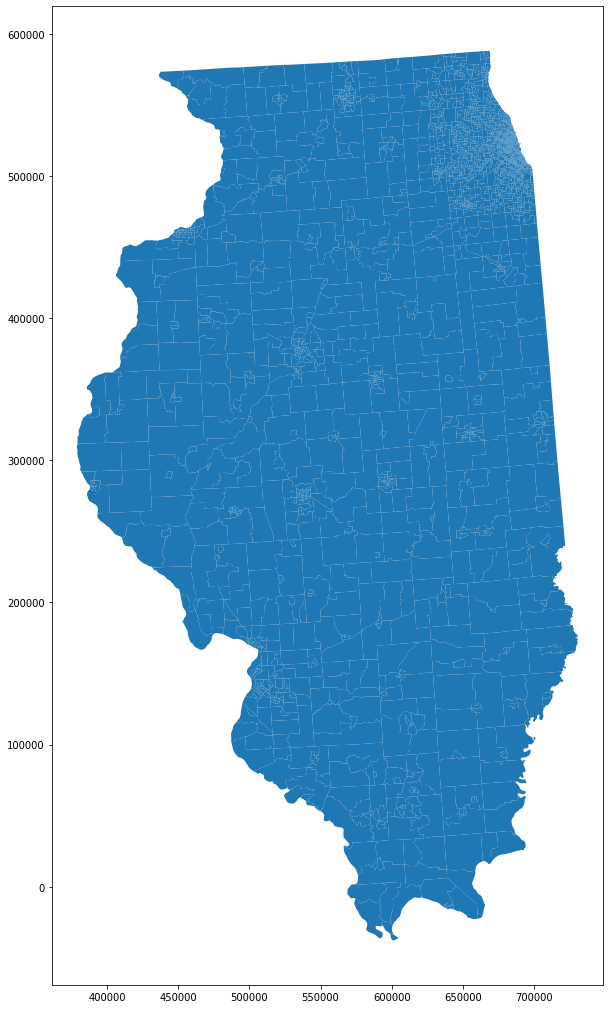

In [8]:
pop_data.plot(figsize=PARAMS["output"]["figsize"])

We can also load the catchments and do a bit of cleaning on those:

* ensure that the amount of hospital beds is positive for each hospital
* ensure that our catchment is a Polygon or Multipolygon (not a line or point)
* project the data

In [9]:
catchments = []
for dist_i, distance in enumerate(PARAMS["region"]["distances"]):
    catchments.append(gpd.read_file(os.path.join(PARAMS["region"]["dir"],PARAMS["region"]["catchment_file_pattern"].format(distance)), driver="GeoJSON"))
    catchments[dist_i] = catchments[dist_i][catchments[dist_i][PARAMS["resource"]["resource"]] > 0]
    catchments[dist_i] = catchments[dist_i].dropna(subset=[PARAMS["resource"]["resource"]])
    catchments[dist_i] = catchments[dist_i][(catchments[dist_i].geom_type == "Polygon") | (catchments[dist_i].geom_type == "MultiPolygon")]
    catchments[dist_i] = catchments[dist_i].to_crs(PARAMS["region"]["projection"])
catchments[0].head()

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1513,0003460644,UHS HARTGROVE HOSPITAL,5730 WEST ROOSEVELT ROAD,CHICAGO,IL,60644,NOT AVAILABLE,(773) 413-1700,PSYCHIATRIC,...,http://www.hartgrovehospital.com,0005454,NOT AVAILABLE,17,PROPRIETARY,-999,128,NOT AVAILABLE,N,"POLYGON ((680612.380 509780.723, 675528.356 50..."
1,1514,0001860612,JESSE BROWN VA MEDICAL CENTER - VA CHICAGO HEA...,820 S DAMEN STREET,CHICAGO,IL,60612,NOT AVAILABLE,(312) 569-8387,MILITARY,...,http://www.chicago.va.gov/,14003F,NOT AVAILABLE,17,GOVERNMENT - FEDERAL,-999,240,NOT AVAILABLE,N,"POLYGON ((685462.211 509236.771, 680281.189 51..."
2,1515,0003160463,PALOS COMMUNITY HOSPITAL,12251 SOUTH 80TH AVENUE,PALOS HEIGHTS,IL,60464,NOT AVAILABLE,(708) 923-4000,GENERAL ACUTE CARE,...,http://www.paloscommunityhospital.org,140062,NOT AVAILABLE,17,NON-PROFIT,-999,377,NOT AVAILABLE,Y,"POLYGON ((678157.519 486927.952, 673323.202 48..."
3,1516,0003660628,ROSELAND COMMUNITY HOSPITAL,45 W 111TH STREET,CHICAGO,IL,60628,NOT AVAILABLE,(773) 995-3000,GENERAL ACUTE CARE,...,http://www.roselandhospital.org,140068,NOT AVAILABLE,17,NON-PROFIT,-999,115,NOT AVAILABLE,N,"POLYGON ((695423.014 490267.854, 695039.134 49..."
4,1517,0002360302,WEST SUBURBAN MEDICAL CENTER,3 ERIE COURT,OAK PARK,IL,60302,NOT AVAILABLE,(708) 383-6200,GENERAL ACUTE CARE,...,http://www.westsuburbanmc.com/Home.aspx,140049,NOT AVAILABLE,17,PROPRIETARY,-999,172,NOT AVAILABLE,N,"POLYGON ((680156.269 513186.258, 676533.665 51..."


<AxesSubplot:>

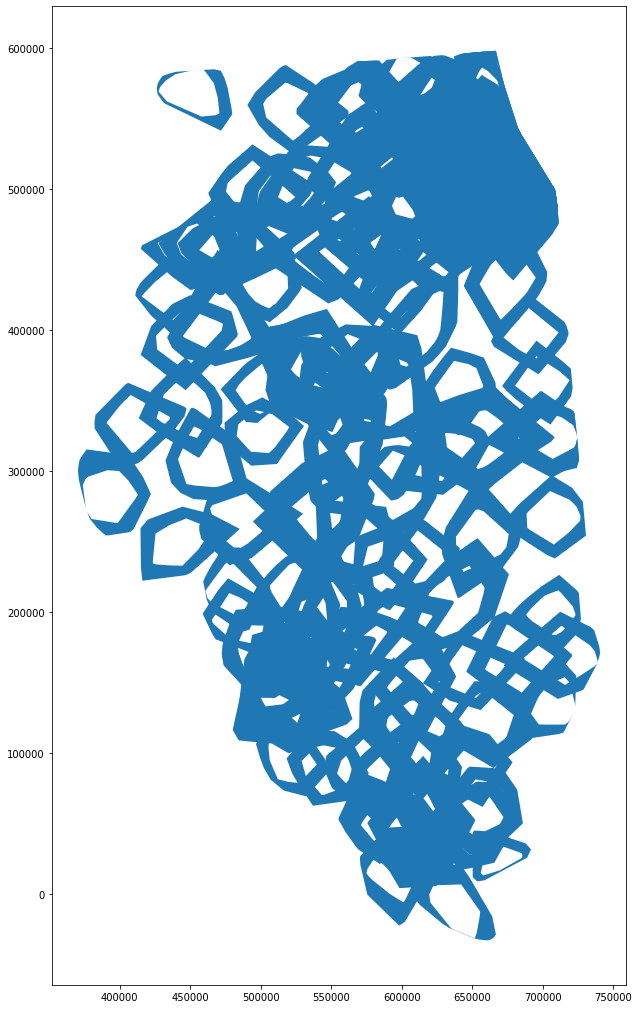

In [10]:
catchments[2].plot(figsize=PARAMS["output"]["figsize"])

In [11]:
result = e2sfca(catchments, PARAMS["access"]["val"], PARAMS["resource"]["key"], 
                pop_data,
                PARAMS["pop"]["pop_key"],
                PARAMS["pop"]["pop_field"],
                PARAMS["resource"]["resource"],
                PARAMS["region"]["distances"],
                PARAMS["access"]["weights"])

Calculating Intersections: 100%|██████████| 3/3 [00:28<00:00,  9.63s/it]


We have our accessibility calculated! Let's check it out:

In [12]:
result.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_STAr,Shape_STLe,geometry,ratio-BEDS
0,17,ILLINOIS,IL,17031,Cook,17031381700,"Census Tract 3817, Cook County, Illinois",0.075986,0,11,...,-999,0,11,-999.0,-999.0,551,0.000021,0.020359,"POLYGON ((689645.410 513172.412, 689877.534 51...",0.004022
1,17,ILLINOIS,IL,17031,Cook,17031980000,"Census Tract 9800, Cook County, Illinois",7.679554,0,11,...,-999,0,11,-999.0,-999.0,38202,0.002171,0.222431,"POLYGON ((662183.100 533025.072, 662292.722 53...",0.004036
2,17,ILLINOIS,IL,17031,Cook,17031980100,"Census Tract 9801, Cook County, Illinois",1.151272,0,11,...,-999,0,11,-999.0,-999.0,6449,0.000323,0.076961,"POLYGON ((678843.600 510378.604, 679647.276 51...",0.003913
3,17,ILLINOIS,IL,17097,Lake,17097863005,"Census Tract 8630.05, Lake County, Illinois",0.393745,440,607,...,-999,0,11,-999.0,-999.0,108,0.000111,0.053599,"POLYGON ((666628.417 566052.998, 666641.522 56...",0.001406
4,17,ILLINOIS,IL,17097,Lake,17097863006,"Census Tract 8630.06, Lake County, Illinois",0.080025,0,11,...,-999,0,11,-999.0,-999.0,2642,0.000023,0.018743,"POLYGON ((666290.205 566023.937, 666268.776 56...",0.001406


Let's project our result and adjust the numbers so they are a bit more human friendly by calculating hospital beds per thousand people rather than per person.

In [13]:
result = result.to_crs(PARAMS["access"]["projection"])

In [14]:
result[PARAMS["access"]["val"]] = result[PARAMS["access"]["val"]] * 1000

Lastly, let's plot our result:

<AxesSubplot:>

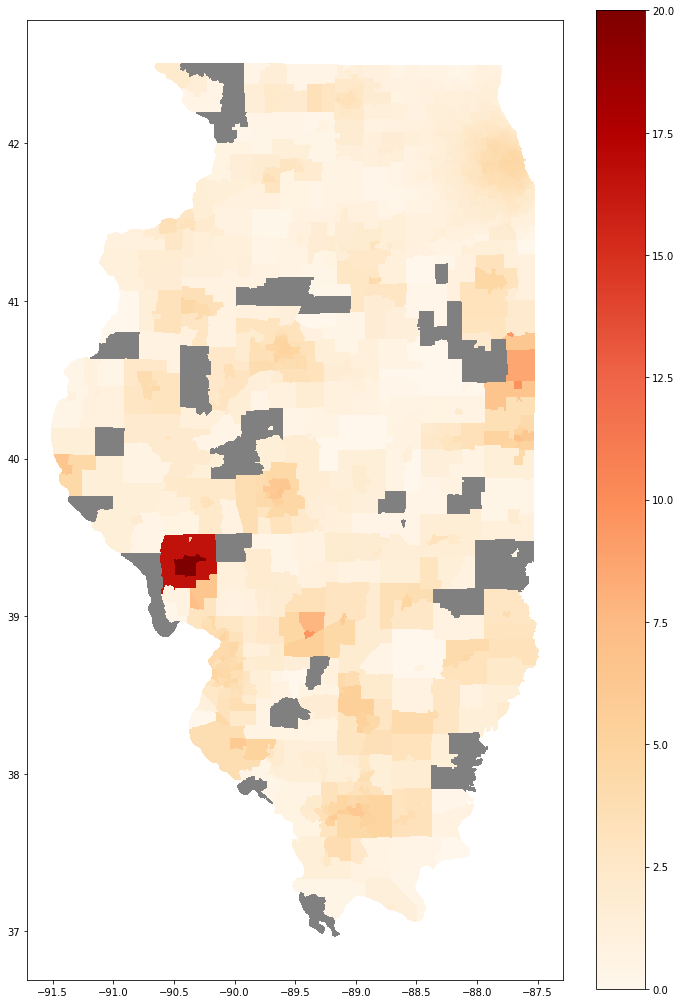

In [15]:
result.plot(column=PARAMS["access"]["val"], cmap="OrRd", legend=True,
            antialiased=False, edgecolor="none", figsize=PARAMS["output"]["figsize"],
            missing_kwds=dict(color='grey'), vmin=0, vmax=20)

<hr id="mw">

# Midwest

In [16]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection": "ESRI:102003"
    },
    "compute": {
        "max_memory" : 20,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/counties/MidwestCounties/MidwestCounties.shp",
        "dir" : "/data/cigi/common/michels9/Midwest-Counties/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/MidwestCounty-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [16,12],
    },
    "pop" : {
        "file": "../data/pop/midwest/Midwest_SVI_CT.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 8,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.geojson",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Midwest",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/midwest/MidwestHospitals.shp"
    }
}
PARAMS["access"]["val"] = "ratio-{}".format(PARAMS["resource"]["resource"])

In [17]:
pop_data = gpd.read_file(PARAMS["pop"]["file"])
pop_data = pop_data.to_crs(PARAMS["region"]["projection"])
pop_data.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_STAr,Shape_STLe,geometry
0,17,ILLINOIS,IL,17031,Cook,17031381700,"Census Tract 3817, Cook County, Illinois",0.075986,0,11,...,-999,-999,0,11,-999.0,-999.0,551,0.000021,0.020359,"POLYGON ((689645.410 513172.412, 689877.534 51..."
1,17,ILLINOIS,IL,17031,Cook,17031980000,"Census Tract 9800, Cook County, Illinois",7.679554,0,11,...,-999,-999,0,11,-999.0,-999.0,38202,0.002171,0.222431,"POLYGON ((662183.100 533025.072, 662292.722 53..."
2,17,ILLINOIS,IL,17031,Cook,17031980100,"Census Tract 9801, Cook County, Illinois",1.151272,0,11,...,-999,-999,0,11,-999.0,-999.0,6449,0.000323,0.076961,"POLYGON ((678843.600 510378.604, 679647.276 51..."
3,17,ILLINOIS,IL,17097,Lake,17097863005,"Census Tract 8630.05, Lake County, Illinois",0.393745,440,607,...,-999,-999,0,11,-999.0,-999.0,108,0.000111,0.053599,"POLYGON ((666628.417 566052.998, 666641.522 56..."
4,17,ILLINOIS,IL,17097,Lake,17097863006,"Census Tract 8630.06, Lake County, Illinois",0.080025,0,11,...,-999,-999,0,11,-999.0,-999.0,2642,0.000023,0.018743,"POLYGON ((666290.205 566023.937, 666268.776 56..."


<AxesSubplot:>

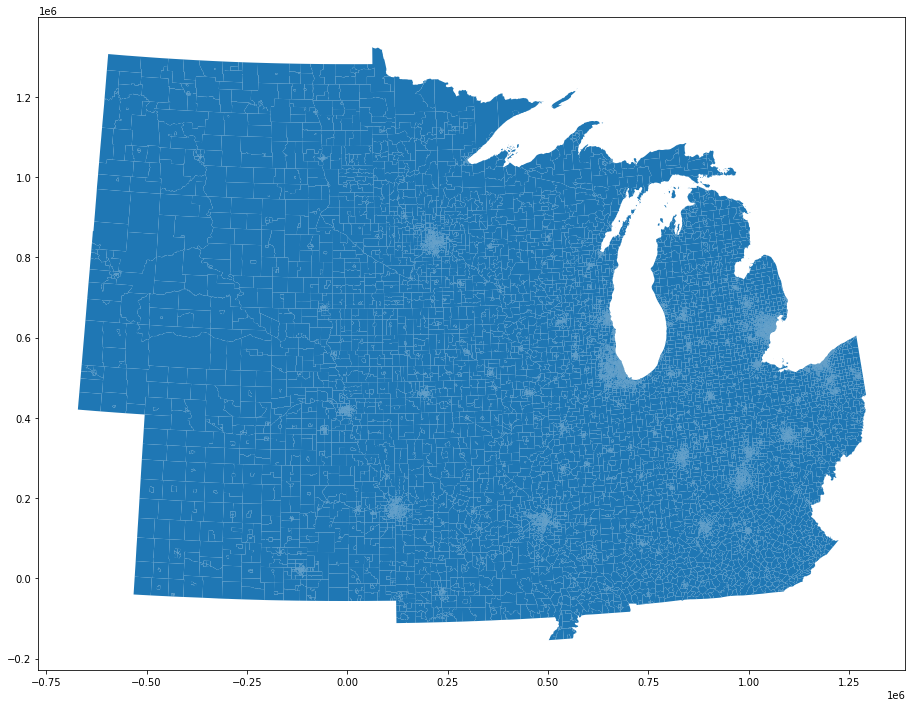

In [18]:
pop_data.plot(figsize=PARAMS["output"]["figsize"])

In [19]:
catchments = []
for dist_i, distance in enumerate(PARAMS["region"]["distances"]):
    catchments.append(gpd.read_file(os.path.join(PARAMS["region"]["dir"],PARAMS["region"]["catchment_file_pattern"].format(distance)), driver="GeoJSON"))
    catchments[dist_i] = catchments[dist_i][catchments[dist_i][PARAMS["resource"]["resource"]] > 0]
    catchments[dist_i] = catchments[dist_i].dropna(subset=[PARAMS["resource"]["resource"]])
    catchments[dist_i] = catchments[dist_i][(catchments[dist_i].geom_type == "Polygon") | (catchments[dist_i].geom_type == "MultiPolygon")]
    catchments[dist_i] = catchments[dist_i].to_crs(PARAMS["region"]["projection"])
catchments[0].head()

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1046,0151453097,COLUMBIA ST MARYS HOSPITAL OZAUKEE,13111 N PORT WASHINGTON RD,MEQUON,WI,53097,NOT AVAILABLE,(262) 243-7300,GENERAL ACUTE CARE,...,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,55,NON-PROFIT,-999,182,NOT AVAILABLE,Y,"POLYGON ((653280.074 660666.996, 645674.248 66..."
1,1058,0150953228,POST ACUTE MEDICAL SPECIALTY HOSPITAL OF MILWA...,5017 S 110TH ST,GREENFIELD,WI,53228,NOT AVAILABLE,(414) 427-8282,LONG TERM CARE,...,http://www.warmsprings.org/our-facilities/hosp...,274,NOT AVAILABLE,55,NOT AVAILABLE,-999,62,NOT AVAILABLE,N,"POLYGON ((642682.714 627634.897, 635552.580 63..."
2,1059,0151054961,THEDACARE MEDICAL CENTER NEW LONDON,1405 MILL ST,NEW LONDON,WI,54961,NOT AVAILABLE,(920) 531-2000,CRITICAL ACCESS,...,https://www.thedacare.org/Hospitals-and-Clinic...,1029,NOT AVAILABLE,55,NOT AVAILABLE,-999,25,LEVEL IV,N,"POLYGON ((577395.424 779225.418, 577177.564 77..."
3,1060,0152254720,OAKLEAF SURGICAL HOSPITAL,1000 OAKLEAF WAY,ALTOONA,WI,54720,NOT AVAILABLE,(715) 831-8130,GENERAL ACUTE CARE,...,http://www.oakleafsurgical.com,303,NOT AVAILABLE,55,NOT AVAILABLE,-999,13,NOT AVAILABLE,N,"POLYGON ((359902.552 816365.198, 351453.543 82..."
4,1074,0011353548,MERCY HLTH SYS CORP,1000 MINERAL POINT AVE,JANESVILLE,WI,53548,NOT AVAILABLE,(608) 756-6080,GENERAL ACUTE CARE,...,http://www.mercyhealthsystem.org,162,NOT AVAILABLE,55,NON-PROFIT,-999,240,LEVEL II,Y,"POLYGON ((568253.663 592187.295, 564156.878 59..."


<AxesSubplot:>

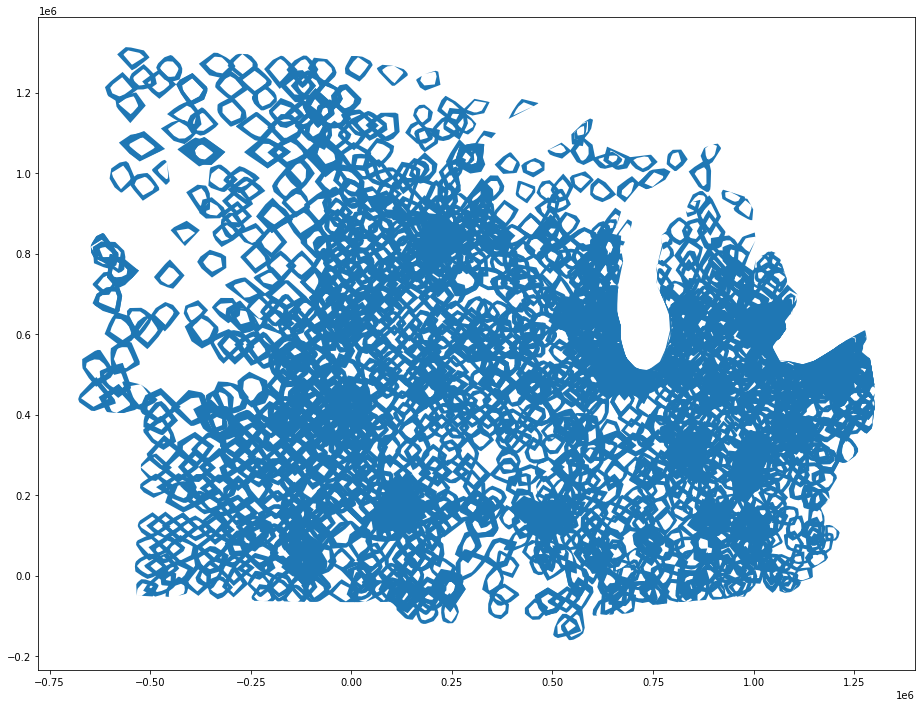

In [20]:
catchments[2].plot(figsize=PARAMS["output"]["figsize"])

In [21]:
result = e2sfca(catchments, PARAMS["access"]["val"], PARAMS["resource"]["key"], 
                   pop_data,
                   PARAMS["pop"]["pop_key"],
                   PARAMS["pop"]["pop_field"],
                   PARAMS["resource"]["resource"],
                   PARAMS["region"]["distances"],
                   PARAMS["access"]["weights"])

Calculating Intersections: 100%|██████████| 3/3 [01:30<00:00, 30.11s/it]


In [22]:
result.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,Shape_STAr,Shape_STLe,geometry,ratio-BEDS
0,17,ILLINOIS,IL,17031,Cook,17031381700,"Census Tract 3817, Cook County, Illinois",0.075986,0,11,...,-999,0,11,-999.0,-999.0,551,0.000021,0.020359,"POLYGON ((689645.410 513172.412, 689877.534 51...",0.004455
1,17,ILLINOIS,IL,17031,Cook,17031980000,"Census Tract 9800, Cook County, Illinois",7.679554,0,11,...,-999,0,11,-999.0,-999.0,38202,0.002171,0.222431,"POLYGON ((662183.100 533025.072, 662292.722 53...",0.004060
2,17,ILLINOIS,IL,17031,Cook,17031980100,"Census Tract 9801, Cook County, Illinois",1.151272,0,11,...,-999,0,11,-999.0,-999.0,6449,0.000323,0.076961,"POLYGON ((678843.600 510378.604, 679647.276 51...",0.004010
3,17,ILLINOIS,IL,17097,Lake,17097863005,"Census Tract 8630.05, Lake County, Illinois",0.393745,440,607,...,-999,0,11,-999.0,-999.0,108,0.000111,0.053599,"POLYGON ((666628.417 566052.998, 666641.522 56...",0.001576
4,17,ILLINOIS,IL,17097,Lake,17097863006,"Census Tract 8630.06, Lake County, Illinois",0.080025,0,11,...,-999,0,11,-999.0,-999.0,2642,0.000023,0.018743,"POLYGON ((666290.205 566023.937, 666268.776 56...",0.001603


In [23]:
result = result.to_crs(PARAMS["access"]["projection"])

In [24]:
result[PARAMS["access"]["val"]] = result[PARAMS["access"]["val"]] * 1000

<AxesSubplot:>

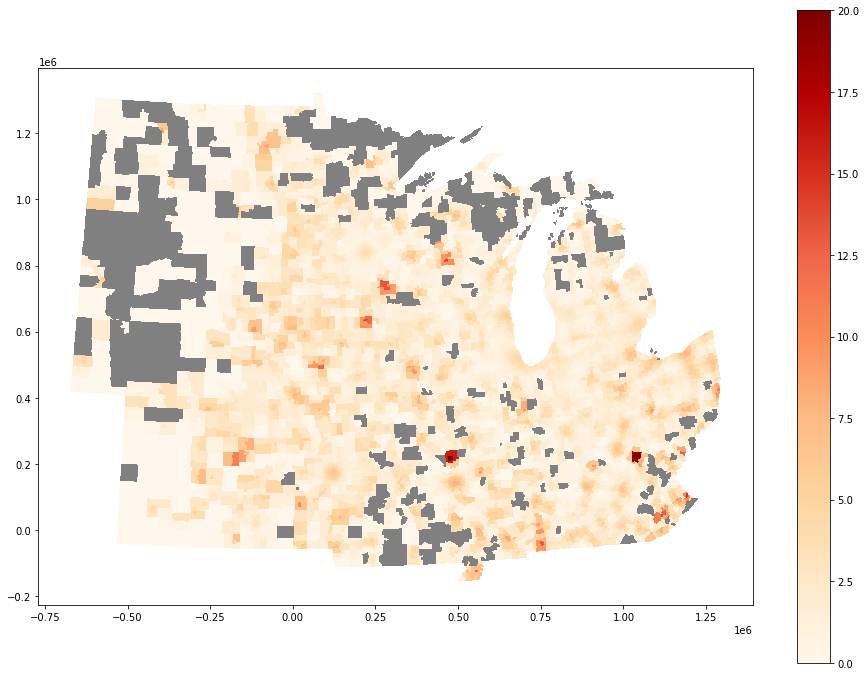

In [25]:
result.plot(column=PARAMS["access"]["val"], cmap="OrRd", legend=True,
            antialiased=False, edgecolor="none", figsize=PARAMS["output"]["figsize"],
            missing_kwds=dict(color='grey'), vmin=0, vmax=20)

<hr id="cont">

# Continental US

In [26]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection" : "ESRI:102003",
    },
    "compute": {
        "max_memory" : 30,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/counties/ContinentalCounties/ContinentalUS.shp",
        "dir" : "/data/cigi/common/michels9/graphmls/Continental/Continental-10kBuffer-20210628/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/Continental-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [20,12],
    },
    "pop" : {
        "file": "../data/pop/continental/Continental_SVI_CT.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 8,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.shp",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Continental",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/continental/ContinentalHospitals.shp"
    }
}
PARAMS["access"]["val"] = "ratio-{}".format(PARAMS["resource"]["resource"])

In [27]:
pop_data = gpd.read_file(PARAMS["pop"]["file"])
pop_data = pop_data.to_crs(PARAMS["region"]["projection"])
pop_data.head()

,FIPS,E_TOTPOP,geometry
0,01015981901,0,"POLYGON ((917741.176 -378823.501, 917800.175 -..."
1,01015981902,0,"POLYGON ((917224.459 -377489.227, 917222.004 -..."
2,01015981903,0,"POLYGON ((938858.539 -378673.916, 939010.699 -..."
3,01097003605,899,"POLYGON ((745344.952 -729566.440, 745471.272 -..."
4,01097990000,0,"MULTIPOLYGON (((760323.731 -749311.532, 760524..."


<AxesSubplot:>

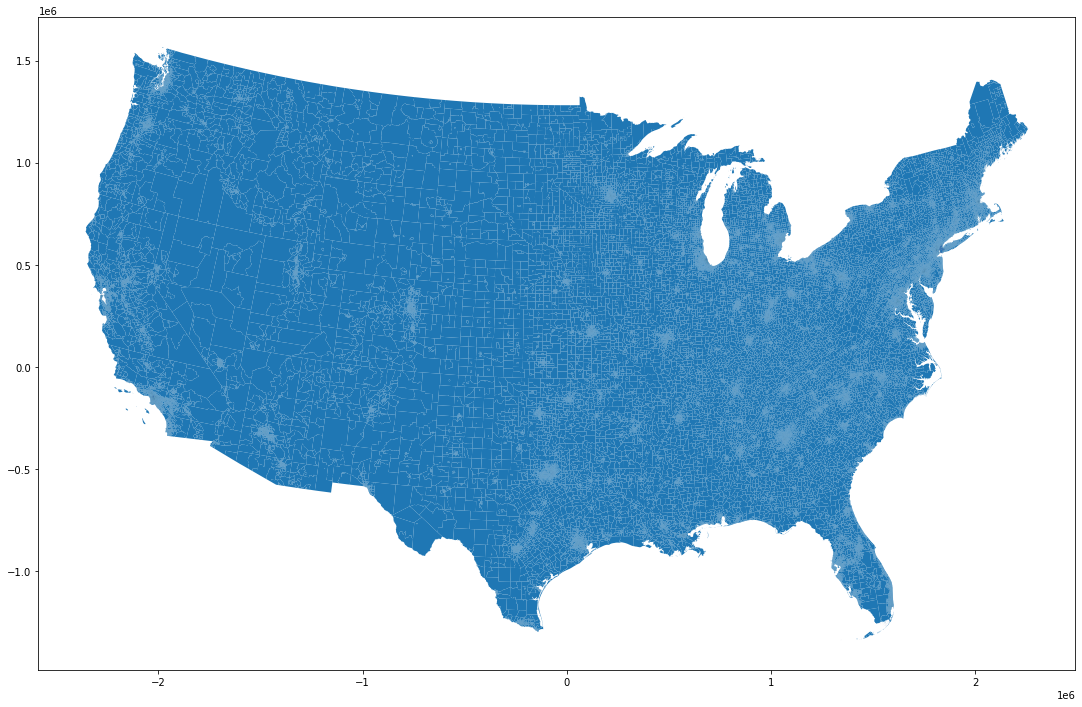

In [28]:
pop_data.plot(figsize=PARAMS["output"]["figsize"])

In [29]:
catchments = []
for dist_i, distance in enumerate(PARAMS["region"]["distances"]):
    catchments.append(gpd.read_file(os.path.join(PARAMS["region"]["dir"],PARAMS["region"]["catchment_file_pattern"].format(distance)), driver="GeoJSON"))
    catchments[dist_i] = catchments[dist_i][catchments[dist_i][PARAMS["resource"]["resource"]] > 0]
    catchments[dist_i] = catchments[dist_i].dropna(subset=[PARAMS["resource"]["resource"]])
    catchments[dist_i] = catchments[dist_i][(catchments[dist_i].geom_type == "Polygon") | (catchments[dist_i].geom_type == "MultiPolygon")]
    catchments[dist_i] = catchments[dist_i].to_crs(PARAMS["region"]["projection"])
catchments[0].head()

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1001,0007892363,COLORADO RIVER MEDICAL CENTER,1401 BAILEY AVENUE,NEEDLES,CA,92363,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.cityofneedles.com/Hospitals.asp,NOT AVAILABLE,NOT AVAILABLE,06,GOVERNMENT - LOCAL,-999,25,NOT AVAILABLE,Y,"POLYGON ((-1671517.016 -148274.103, -1679826.8..."
1,1002,0001392120,ALVARADO HOSPITAL MEDICAL CENTER,6655 ALVARADO ROAD,SAN DIEGO,CA,92120,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.alvaradohospital.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,226,NOT AVAILABLE,N,"POLYGON ((-1944169.158 -322503.070, -1952737.1..."
2,1003,0001591942,ALVARADO PARKWAY INSTITUTE B.H.S.,7050 PARKWAY DRIVE,LA MESA,CA,91942,NOT AVAILABLE,NOT AVAILABLE,PSYCHIATRIC,...,http://www.apibhs.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,66,NOT AVAILABLE,N,"POLYGON ((-1945959.735 -323698.622, -1953135.7..."
3,1004,0023292104,KINDRED HOSPITAL - SAN DIEGO,1940 EL CAJON BOULEVARD,SAN DIEGO,CA,92104,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.kindredsandiego.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,70,NOT AVAILABLE,N,"POLYGON ((-1952419.805 -325676.992, -1958077.4..."
4,1005,0034392050,PARADISE VALLEY HOSPITAL,2400 EAST FOURTH STREET,NATIONAL CITY,CA,92050,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.paradisevalleyhospital.org,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,227,NOT AVAILABLE,N,"POLYGON ((-1948665.744 -335003.626, -1952238.7..."


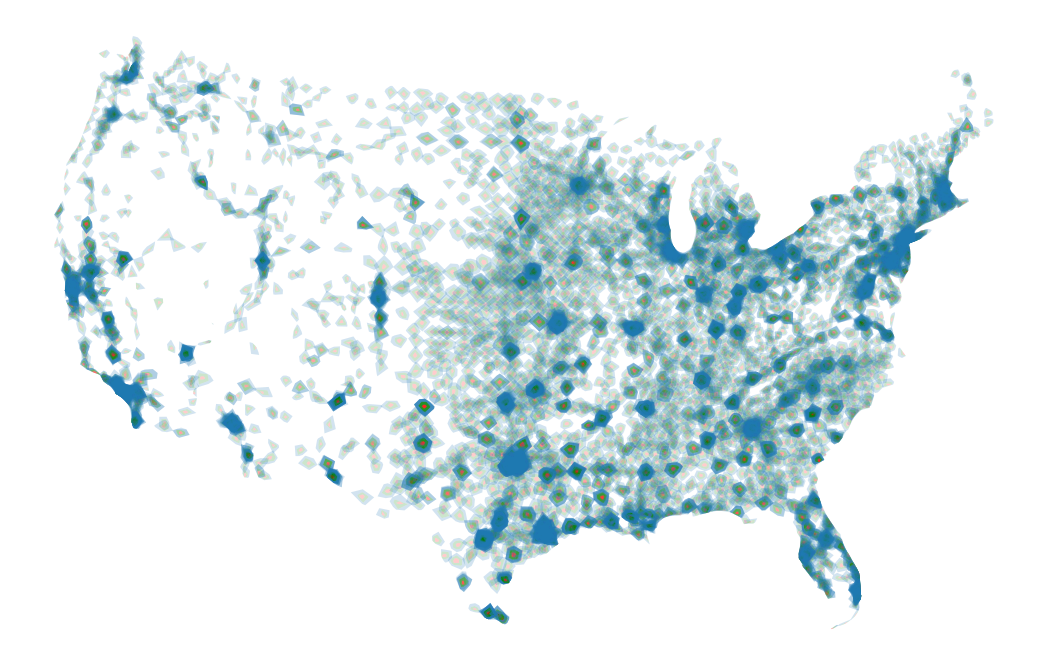

In [30]:
alpha = 0.2
ax = catchments[0].plot(figsize=PARAMS["output"]["figsize"], alpha=alpha, color='red')
catchments[1].plot(ax=ax, alpha=alpha, color='green')
catchments[2].plot(ax=ax, alpha=alpha)
ax.axis('off')
plt.show()

In [31]:
result = e2sfca(catchments, PARAMS["access"]["val"], PARAMS["resource"]["key"], 
                   pop_data,
                   PARAMS["pop"]["pop_key"],
                   PARAMS["pop"]["pop_field"],
                   PARAMS["resource"]["resource"],
                   PARAMS["region"]["distances"],
                   PARAMS["access"]["weights"])

Calculating Intersections: 100%|██████████| 3/3 [07:00<00:00, 140.20s/it]


In [32]:
result.head()

,FIPS,E_TOTPOP,geometry,ratio-BEDS
0,01015981901,0,"POLYGON ((917741.176 -378823.501, 917800.175 -...",0.004036
1,01015981902,0,"POLYGON ((917224.459 -377489.227, 917222.004 -...",0.005465
2,01015981903,0,"POLYGON ((938858.539 -378673.916, 939010.699 -...",0.004035
3,01097003605,899,"POLYGON ((745344.952 -729566.440, 745471.272 -...",0.005309
4,01097990000,0,"MULTIPOLYGON (((760323.731 -749311.532, 760524...",0.001416


In [33]:
result = result.to_crs(PARAMS["access"]["projection"])

In [34]:
result[PARAMS["access"]["val"]] = result[PARAMS["access"]["val"]] * 1000

<AxesSubplot:>

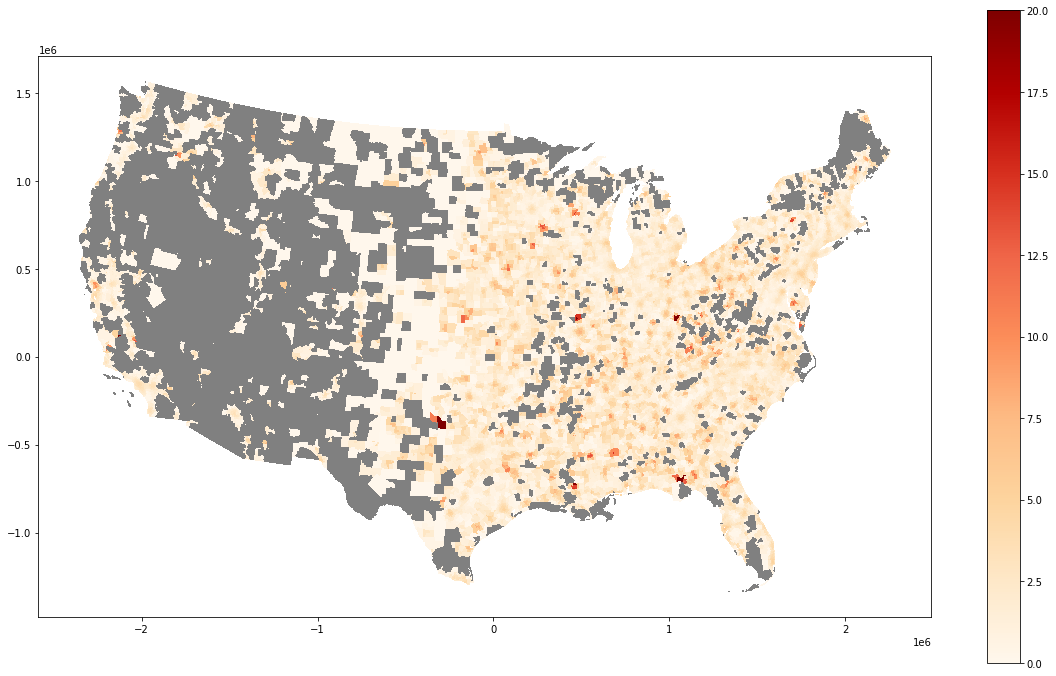

In [35]:
result.plot(column=PARAMS["access"]["val"], cmap="OrRd", legend=True,
            antialiased=False, edgecolor="none", figsize=PARAMS["output"]["figsize"],
            missing_kwds=dict(color='grey'), vmin=0, vmax=20)